Import Libraries

In [3]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import nltk

nltk.download('all')

import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

Load the dataset and remove invalid data

In [4]:
raw_data = pd.read_csv('categories.csv', sep = ';', header = None)

In [5]:
raw_data.columns = ["Text", "Class"]

In [6]:
raw_data = raw_data.dropna()
raw_data.head(10)

,Text,Class
0,i feel lots of crypto has exhausted itself,1.0
1,How are you guys feeling today ??? :Bear: or ...,1.0
2,Did not take a trade today,1.0
3,Just entered eos long trade 👌,1.0
4,Anything good to buy now? Or did I miss it 😭,1.0
5,GL trading tonight guys. I'm off to eat dinne...,1.0
6,Okay my long position is still open on eth,1.0
7,morning guys any trades avaiable?,1.0
8,What’s everybodies thoughts today?,1.0
9,Are you guys more bullish or bearish for this ...,1.0


<Axes: >

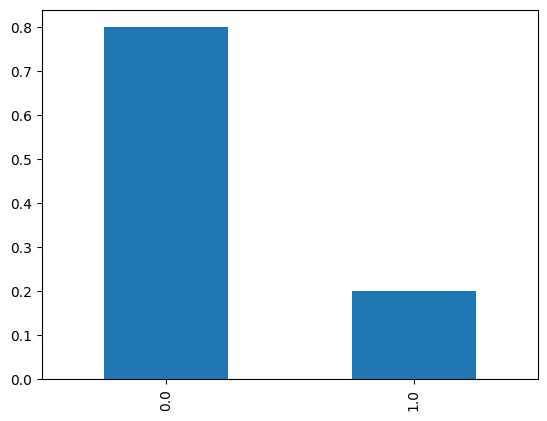

In [7]:
raw_data['Class'].value_counts(normalize = True).plot.bar()

In [8]:
class_1_data = raw_data[raw_data["Class"] == 1]
class_0_data = raw_data[raw_data["Class"] == 0]

In [9]:
print("Samples of Class 0 : ", len(class_0_data.index))
print("Samples of Class 1 : ", len(class_1_data.index))

Samples of Class 0 :  23099
Samples of Class 1 :  5762


all sentences belonging to class 1 + randomly selected the same amount of sentences belonging to class 0

In [10]:
balanced_dataset = pd.concat([class_1_data, class_0_data.sample(len(class_1_data.index))], ignore_index=True)

In [11]:
print("Samples of Balanced Dataset : ", len(balanced_dataset.index))

Samples of Balanced Dataset :  11524


text pre-processing

In [12]:
text_list = list(balanced_dataset['Text'])
class_list = list(balanced_dataset['Class'])

In [13]:
def preprocessing(text_list, class_list):
  corpus = []
  classes = []
  for i in range(len(text_list)):
    try:
      r = re.sub('[^a-zA-Z]', ' ', text_list[i])
      r = r.lower()
      r = r.split()
      r = [word for word in r if word not in stopwords.words('english')]
      r = [lemmatizer.lemmatize(word) for word in r]
      r = ' '.join(r)
      corpus.append(r)
      classes.append(int(class_list[i]))
    except:
      print(text_list[i])
  return corpus, classes

In [14]:
corpus, classes = preprocessing(text_list, class_list)

Split the data into train, validation and test sets

In [20]:
X = corpus
y = classes

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

# **Tokenization**
- splitting sentences into words
- get Vocabulary size

In [22]:
max_len = 20
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  3427


# **Encoding the word into numeric**

In [23]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

- convert list of int into numpy array

In [24]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# **Building a Transformer**

In [26]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# **Building a Model**

In [27]:
embed_dim = 40
heads = 2
neurons = 32
maxlen = 20

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

- Model Compiling

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddi  (None, 20, 40)            137880    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, 20, 40)            15872     
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 40)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 40)                0     

# **Training a Model**

In [29]:
model_name = "checkpoint.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [30]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
289/289 [==============================] - 8s 16ms/step - loss: 0.4498 - accuracy: 0.7860 - val_loss: 0.2037 - val_accuracy: 0.9288
Epoch 2/25
289/289 [==============================] - 6s 22ms/step - loss: 0.1828 - accuracy: 0.9395 - val_loss: 0.1752 - val_accuracy: 0.9340
Epoch 3/25
289/289 [==============================] - 4s 14ms/step - loss: 0.1510 - accuracy: 0.9477 - val_loss: 0.1581 - val_accuracy: 0.9444
Epoch 4/25
289/289 [==============================] - 7s 25ms/step - loss: 0.1362 - accuracy: 0.9528 - val_loss: 0.1940 - val_accuracy: 0.9375
Epoch 4: early stopping


- Predict the test set and display ROC Curve

37/37 [==============================] - 0s 4ms/step


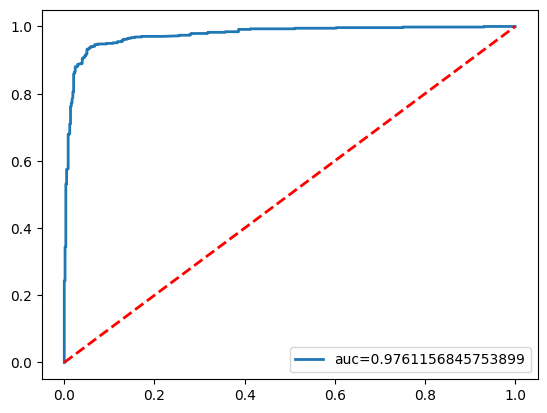

In [32]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

- Scoring the predicted result

In [33]:
prediction = y_pred

In [34]:
prediction[y_pred>=0.5] = 1
prediction[y_pred<0.5] = 0

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       577
           1       0.90      0.95      0.93       576

    accuracy                           0.92      1153
   macro avg       0.93      0.92      0.92      1153
weighted avg       0.93      0.92      0.92      1153



              precision    recall  f1-score   support

           0       0.95      0.90      0.92       577
           1       0.90      0.95      0.93       576

    accuracy                           0.92      1153
   macro avg       0.93      0.92      0.92      1153
weighted avg       0.93      0.92      0.92      1153



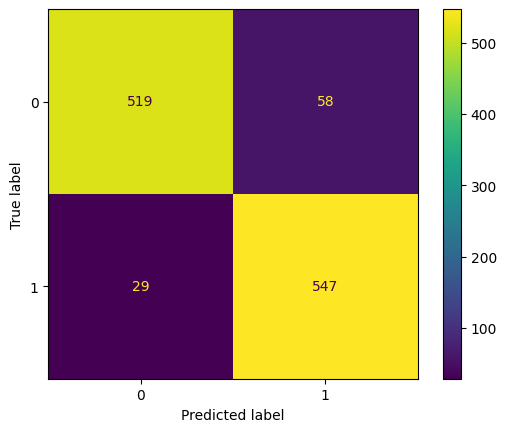

In [35]:
# Create the confusion matrix
cm = confusion_matrix(y_test, prediction)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_test,y_pred))

- Save the model

In [36]:
model.save_weights("transformer_model.h5")

- Load the model

In [37]:
model.load_weights('transformer_model.h5')

# **Predict the new input**

In [47]:
new_input = ["What’s everybodies thoughts today?", "Anything good to buy now? Or did I miss it "]


In [48]:
def process_input(text_list):
  corpus = []
  for i in range(len(text_list)):
    try:
      r = re.sub('[^a-zA-Z]', ' ', text_list[i])
      r = r.lower()
      r = r.split()
      r = [word for word in r if word not in stopwords.words('english')]
      r = [lemmatizer.lemmatize(word) for word in r]
      r = ' '.join(r)
      corpus.append(r)
    except:
      print(text_list[i])
  return corpus

- Preprocessing

In [49]:
input = process_input(new_input)
input

['everybodies thought today', 'anything good buy miss']

- Word Encoding

In [50]:
input_sequences = tokenizer.texts_to_sequences(input)
input = pad_sequences(input_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [51]:
input = np.array(input)

- Predict the input

In [52]:
pred = model.predict(input)
pred


1/1 [==============================] - 0s 27ms/step


array([[0.9486213],
       [0.8631268]], dtype=float32)

- Scoring the result

In [53]:
pred[pred>=0.5] = 1
pred[pred<0.5] = 0

In [55]:
pred

array([[1.],
       [1.]], dtype=float32)